In [370]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
from scipy.optimize import curve_fit
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from models import *

## Load data to fit "ground truth" curves

In [371]:
bat_dict = pickle.load(open(r'../Data/bat_dict_small.pkl', 'rb'))

In [372]:
def func(x, a, b, c):
    #return np.exp(a/temps)*x**b + c
    return np.exp(a)*x**b + c

In [409]:
params = []
cycle_lives = []
for id in bat_dict.keys():
    bat = bat_dict[id]
    #temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QD'][1:]/1.1
    length = len(bat['summary']['QD'][1:])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])
    
    cycle_lives.append(bat["cycle_life"][0])
params = np.array(params)
cycle_lives = np.array(cycle_lives)

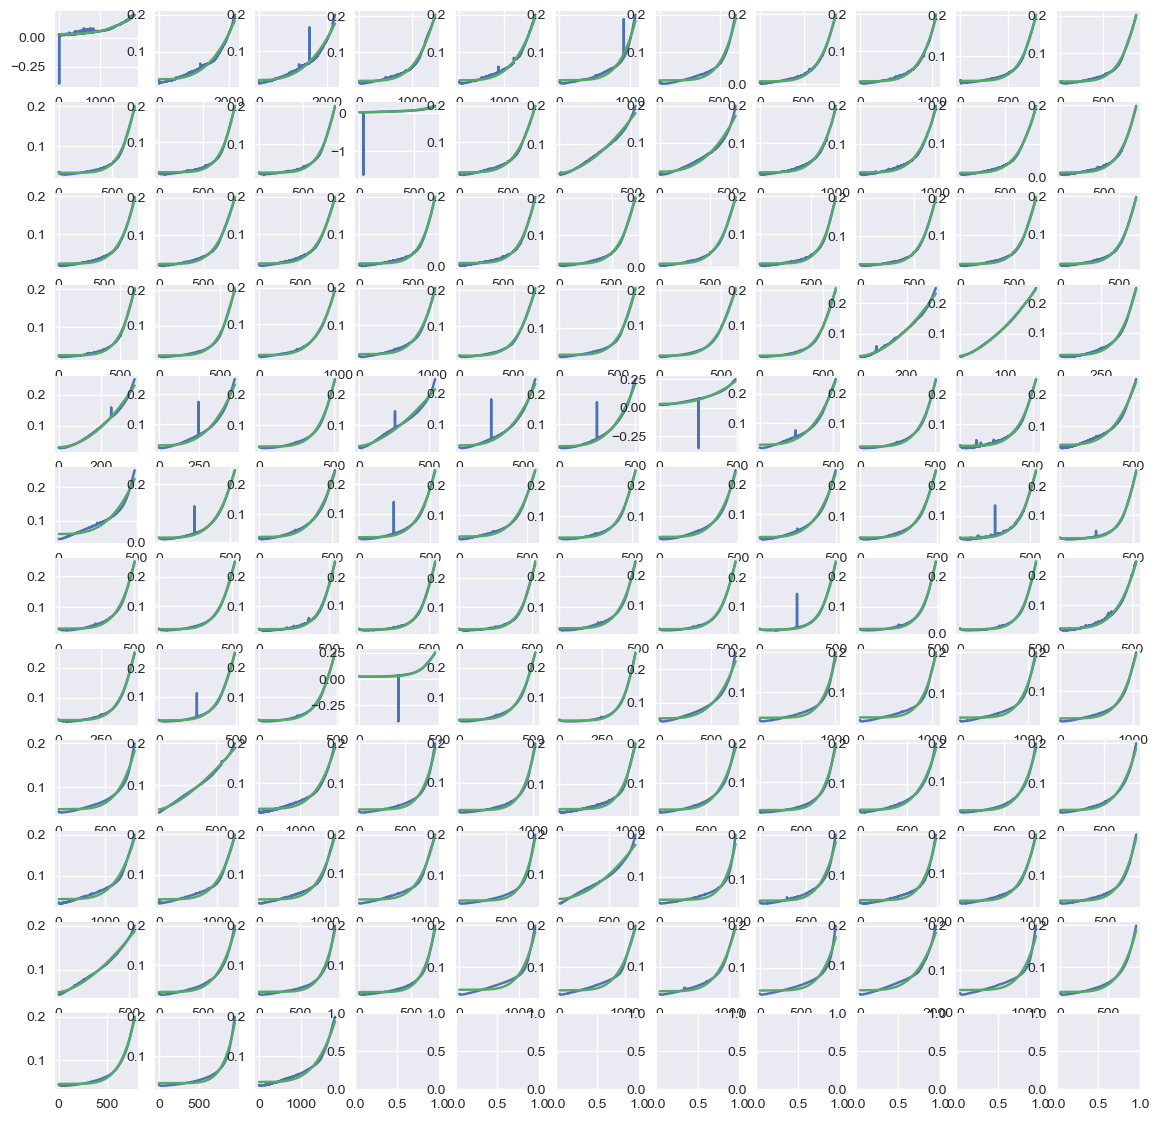

In [410]:
# visualize curve fits
fig,axs=plt.subplots(nrows=12,ncols=11,figsize=(14,14))
for ix,id in enumerate(bat_dict.keys()):
    ax = axs[int(ix/11)][ix%11]
    length = len(bat_dict[id]['summary']['QD'][1:])
    x = np.arange(1,length+1)
    Y = 1-bat_dict[id]['summary']['QD'][1:]/1.1
    ax.plot(x, Y)

    alpha = params[ix][0]
    beta = params[ix][1]
    gamma = params[ix][2]
    ax.plot(x, func(x,alpha,beta,gamma), linestyle="-")

## Load data for predictive model

In [411]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [412]:
data = pickle.load(open(r'../Data/sev_deltaQ_cycles.pkl', 'rb'))
n_cycles = 98
cut_start = 0

features = [
    "DeltaQ_logVars",
    "DeltaQ_mins",
    # "DeltaQ_means",
    # "DeltaT_max",
    "DeltaT_logVars",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:n_cycles]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(params[train_ind]))
test = TensorDataset(torch.Tensor(x[test_ind]),torch.Tensor(params[test_ind]))
stest = TensorDataset(torch.Tensor(x[secondary_ind]),torch.Tensor(params[secondary_ind]))

In [413]:
class AutoEncoder_ElasticNet(nn.Module):
    def __init__(self, n_features, n_cycles=49, alpha=0.5):
        super(AutoEncoder_ElasticNet, self).__init__()

        self.alpha = alpha
        self.n_features = n_features
        self.n_cycles = n_cycles

        self.encoder = nn.Sequential(
            nn.Linear(n_features*n_cycles, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*16),
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_features*16, n_features*32),
            nn.ReLU(),
            nn.Linear(n_features*32, n_features*n_cycles)
        )

        self.prediction = nn.Linear(n_features*16, 1)

    def prediction_loss(self):
        l1_norm = self.prediction.weight.abs().sum()
        l2_norm = self.prediction.weight.pow(2).sum()
        return (1-self.alpha)/2 * l2_norm + self.alpha * l1_norm
    
    def predict(self, x):
        self.eval()
        return self.prediction(self.encoder(x))
    
    def forward(self, x):
        self.eval()
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def evaluate(self, x, y):
        mses = [0.0, 0.0, 0.0]
        for i in train_ind:
            mses[0] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2
        for i in test_ind:
            mses[1] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2
        for i in secondary_ind:
            mses[2] += (10**self.predict(x[i].expand((1, *x[i].size()))).detach().numpy() - 10**y[i].detach().numpy())**2

        mses[0] = np.sqrt(mses[0] / len(train_ind))
        mses[1] = np.sqrt(mses[1] / len(test_ind))
        mses[2] = np.sqrt(mses[2] / len(secondary_ind))

        for mse, label in zip(mses, ["\ntrain", "test", "sec"]):
            print(label, "\t", mse[0])

    def plotter(self, x, y, id):
        fig, axs = plt.subplots(1, 2)

        for i in range(self.n_features):
            axs[0].plot(x[id].detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], 
                        self.forward(x[id]).detach().numpy()[i*self.n_cycles:(i+1)*self.n_cycles], "o", label = "feature {}".format(i+1))
        axs[0].plot(np.linspace(-5.5, 1.5, 3), np.linspace(-5.5, 1.5, 3), "k", alpha = 0.5)

        axs[0].legend(fontsize = 14)
        axs[0].set_xlabel("True input", fontsize = 16)
        axs[0].set_ylabel("Decoded input", fontsize = 16)
        axs[0].tick_params(axis='x', labelsize=14)
        axs[0].tick_params(axis='y', labelsize=14)
        axs[0].set_title("Decoder performance, cell "+str(id), fontsize = 20)

        axs[1].plot(10**y[train_ind], 10**self.predict(x[train_ind]).detach().numpy(), "o", label = "train")
        axs[1].plot(10**y[test_ind], 10**self.predict(x[test_ind]).detach().numpy(), "o", label = "test")
        axs[1].plot(10**y[secondary_ind], 10**self.predict(x[secondary_ind]).detach().numpy(), "o", label = "secondary")
        axs[1].plot(np.linspace(200, 2400, 3), np.linspace(200, 2400, 3), "k", alpha = 0.5)

        axs[1].legend(fontsize = 14)
        axs[1].set_xlabel("True lifetime", fontsize = 16)
        axs[1].tick_params(axis='x', labelsize=14)
        axs[1].tick_params(axis='y', labelsize=14)
        axs[1].set_ylabel("Predicted lifetime", fontsize = 16)
        axs[1].set_title("Prediction performance", fontsize = 20)

        plt.show()

    def fit(self, x, y, train_policy, verbose = True, plots = True, log_loss = False):

        self.train()
        loss_function = nn.MSELoss()
        train_data = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))

        num_stages = train_policy["num_stages"]
        for stage in range(num_stages):
            if verbose: print("Stage {}:\n".format(stage+1))

            epochs = train_policy["epochs"][stage]
            lr = train_policy["learning_rates"][stage]
            batch_size = train_policy["batch_sizes"][stage]
            prediction_weight = train_policy["prediction_weights"][stage]
            decoding_weight = train_policy["decoding_weights"][stage]
            en_weight = train_policy["decoding_weights"][stage]

            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            optimiser = torch.optim.Adam(self.parameters(), lr=lr)

            for ep in range(epochs):
                for batch in train_loader:
                    train_inputs, train_labels = batch
                    # train_inputs = train_inputs + torch.normal(mean=0,std=1,size=(train_inputs.size()[0], train_inputs.size()[1]))
                    outputs = self.forward(train_inputs)
                    predictions = self.predict(train_inputs)

                    if log_loss: prediction_loss = loss_function(train_labels, predictions[:, 0])
                    else: prediction_loss = loss_function(10**train_labels, 10**predictions[:, 0])
                    decoding_loss = loss_function(train_inputs, outputs)
                    en_loss = self.prediction_loss()
                    loss = en_loss*en_weight + decoding_loss*decoding_weight + prediction_loss*prediction_weight

                    optimiser.zero_grad()
                    loss.backward()
                    optimiser.step()

                if verbose:    
                    if (ep+1) % int(epochs / 10) == 0: print(f"Epoch {ep+1}/{epochs},   \tdecoding loss: {decoding_loss.item():.2f},    \tprediction loss: {prediction_loss.item():.2f},  \treg_loss: {en_loss.item():.2f}")

            if verbose: self.evaluate(x, y)
            if plots: self.plotter(x, y, 30)
                
class AttentionModel(torch.nn.Module):
    def __init__(self, d_model, feat_dim, n_cycle, vdim=1, num_heads=1, attn_model="softmax", beta=1, skip_connect=0):
        super(AttentionModel, self).__init__()
        '''d_model: embedding dimension; can be chosen independently of input data dimensions
           feat_dim: number of features in a cycle
           n_cycle: number of "cycles" outputted by the encoder / number of tokens, each of which has feat_dim features
           vdim: dimension of output, 1 for our regression problem
           num_heads: default 1
           attn_model: default softmax; code also supports batch normalized attention with keyword "batch_norm"
           beta: if using batch normalized attention, beta is the weight placed on the mean
           skip_connect: whether or not to add a skip connection. If 0, no skip connection. If 1, H=AV+B where B
           is a trainable projection of the input X. If 2, H=AV+V'''
        assert d_model % num_heads == 0, "Embedding dimension (d_model) must be divisible by number of attention heads (num_heads)."
        
        self.W_q = nn.Linear(feat_dim, d_model)
        self.W_k = nn.Linear(feat_dim, d_model)
        self.W_v = nn.Linear(feat_dim, vdim)
        self.W_b = nn.Linear(feat_dim, vdim)

        #self.create_output = nn.Linear(n_cycle,1) # final linear layer to collapse output

        self.d_model = d_model
        self.vdim = vdim
        self.num_heads = num_heads
        #self.head_dim = d_model // num_heads
        
        self.attn_model = attn_model
        self.beta = beta
        self.skip_connect = skip_connect

    def scaled_dot_product_attention(self, Q, K, V, B): 
        '''softmax attention'''
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_model // self.num_heads)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, n_cycle, n_cycle)
        output = torch.matmul(attn_probs, V) # dimensionality (batch size, n_cycle, vdim)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def batch_normalized_attention(self, Q, K, V, B):
        '''batch normalized attention'''
        mu = torch.mean(K,0)
        s = torch.std(K,0,correction=0)
        attn_scores = torch.matmul(torch.mul(Q-self.beta*mu,s), torch.mul(K-self.beta*mu,s).transpose(-2,-1)) / math.sqrt(self.d_model)
        attn_probs = torch.softmax(attn_scores, dim=-1) # attention matrix, dimensionality (batch size, batch size)
        output = torch.matmul(attn_probs, V)
        if self.skip_connect == 1:
            output = output + B
        elif self.skip_connect == 2:
            output = output + V
        return output
    
    def forward(self, X):
        if len(X.size()) < 3:
            X = X[...,None] # add a feature dimension if there is none
        Q = self.W_q(X) # create query matrix, dimensionality (batch size, n_cycle, d_model)
        K = self.W_k(X) # create key matrix, dimensionality (batch size, n_cycle, d_model)
        V = self.W_v(X) # create value matrix, dimensionality (batch size, n_cycle, vdim)
        B = self.W_b(X) # create matrix for skip connection, dimensionality (batch size, n_cycle, vdim)

        # replaced final linear layer with just an averaging layer (gave better results earlier, can try putting linear layer back) 
        if self.attn_model=="softmax": attn_output = self.scaled_dot_product_attention(Q, K, V, B)
        elif self.attn_model=="batch_norm": attn_output = self.batch_normalized_attention(Q, K, V, B)
        # attn_output has dimensionality (batch_size, n_cycle, vdim)
        output = torch.mean(attn_output.transpose(-2,-1),dim=-1) # dimensionality (batch_size, vdim)
        #output = self.create_output(attn_output.transpose(-2,-1)) # dimensionality (batch size, 1, 1)
        return output

Stage 1:

Epoch 250/2500,   	decoding loss: 0.13,    	prediction loss: 556656.81,  	reg_loss: 1.76
Epoch 500/2500,   	decoding loss: 0.06,    	prediction loss: 556196.50,  	reg_loss: 1.22
Epoch 750/2500,   	decoding loss: 0.04,    	prediction loss: 555254.00,  	reg_loss: 0.84
Epoch 1000/2500,   	decoding loss: 0.03,    	prediction loss: 553589.06,  	reg_loss: 0.56
Epoch 1250/2500,   	decoding loss: 0.03,    	prediction loss: 550613.88,  	reg_loss: 0.39
Epoch 1500/2500,   	decoding loss: 0.03,    	prediction loss: 545098.25,  	reg_loss: 0.26
Epoch 1750/2500,   	decoding loss: 0.03,    	prediction loss: 534730.00,  	reg_loss: 0.14
Epoch 2000/2500,   	decoding loss: 0.02,    	prediction loss: 513654.59,  	reg_loss: 0.04
Epoch 2250/2500,   	decoding loss: 0.02,    	prediction loss: 104057.94,  	reg_loss: 0.32
Epoch 2500/2500,   	decoding loss: 0.03,    	prediction loss: 49718.53,  	reg_loss: 0.21

train 	 [221.61145]
test 	 [269.2319]
sec 	 [289.87823]


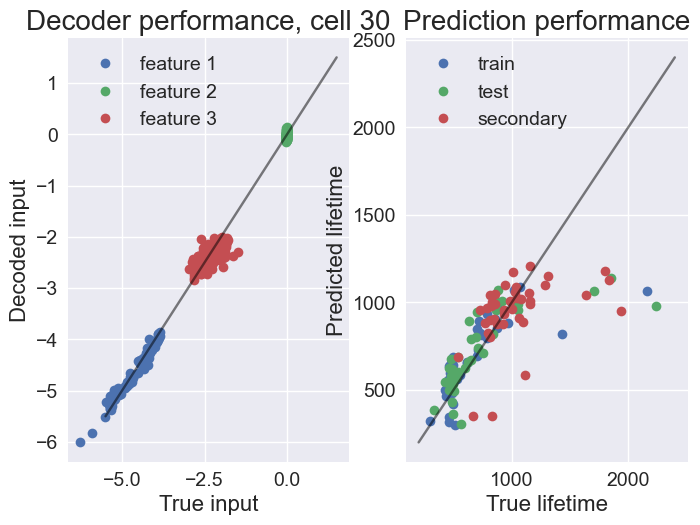

In [414]:
train_policy = {
    "num_stages": 1,
    "epochs": [2500],
    "learning_rates": [5e-4],
    "batch_sizes": [64, 64],
    "prediction_weights": [1/5000],
    "decoding_weights": [50],
    "en_weights": [50]
}


model = AutoEncoder_Attention(n_features=len(features), n_cycles=n_cycles, attention_embedding=4)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [415]:
x_train = model.encoder(x[train_ind]).detach().numpy()
x_test = model.encoder(x[test_ind]).detach().numpy()
x_stest = model.encoder(x[secondary_ind]).detach().numpy()

y_train = params[train_ind]
y_test = params[test_ind]
y_stest = params[secondary_ind]

life_train = cycle_lives[train_ind]
life_test = cycle_lives[test_ind]
life_stest = cycle_lives[secondary_ind]

train = TensorDataset(torch.Tensor(x_train),torch.Tensor(y_train),torch.Tensor(life_train))
test = TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test),torch.Tensor(life_test))
stest = TensorDataset(torch.Tensor(x_stest),torch.Tensor(y_stest),torch.Tensor(life_stest))

In [416]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## First round of training (calc loss w/ model parameters)

In [417]:
d_model = 4
feat_dim = 1
n_cycle = np.shape(x_train)[1]
attn_model = "softmax"
skip_connect = 0
nepoch = 500
lr = 1e-3
batch_size = 1

In [419]:
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return torch.sum( torch.mul(((inputs - targets)**2 ), weights) )
    
model = AttentionModel(d_model=d_model,feat_dim=feat_dim,n_cycle=n_cycle,vdim=3,attn_model=attn_model,skip_connect=skip_connect)
criterion = weighted_MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label, _ = batch
        output = model(train_input.to(device))
        
        loss = criterion(output, train_label, weights=torch.tensor([1/32,1/4,1/0.02]))
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label, _ = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(test_output, test_label, weights=torch.tensor([1/32,1/4,1/0.02]))

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, _ = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(stest_output, stest_label, weights=torch.tensor([1/32,1/4,1/0.02]))
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 50 | rmse:  5.395 | rmse_test:  5.319 | rmse_stest:  6.417
Epochs: 100 | rmse:  4.402 | rmse_test:  4.324 | rmse_stest:  5.434
Epochs: 150 | rmse:  1.772 | rmse_test:  1.760 | rmse_stest:  2.666
Epochs: 200 | rmse:  1.242 | rmse_test:  1.333 | rmse_stest:  1.800
Epochs: 250 | rmse:  1.219 | rmse_test:  1.348 | rmse_stest:  1.827
Epochs: 300 | rmse:  1.227 | rmse_test:  1.318 | rmse_stest:  1.773
Epochs: 350 | rmse:  1.198 | rmse_test:  1.308 | rmse_stest:  1.759
Epochs: 400 | rmse:  1.209 | rmse_test:  1.305 | rmse_stest:  1.796
Epochs: 450 | rmse:  1.198 | rmse_test:  1.296 | rmse_stest:  1.717
Epochs: 500 | rmse:  1.201 | rmse_test:  1.274 | rmse_stest:  1.750


286.94563268292796
353.02410511140954
373.8121964887926


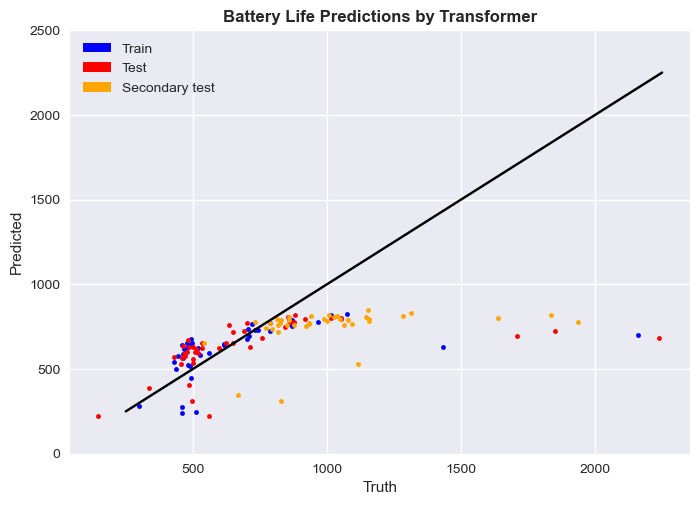

In [420]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])

        predicted.append(pred_life)
        labels.append(true_life[0])
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)

## Second round of training (calc loss w/ cycle lifetime)

In [424]:
# low learning rate and many epochs for fine-tuning
lr_fine = 1e-5
optimizer_fine = torch.optim.Adam(model.parameters(), lr=lr_fine)
nepoch = 5000
criterion = nn.MSELoss().to(device)

In [ ]:
# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer_fine.zero_grad()
        train_input, train_label, true_life = batch
        output = model(train_input.to(device))

        # calculate lifetime using closed-form equation
        pred_life = torch.pow(torch.exp(-output[:,0])*(0.2-output[:,2]),1/output[:,1])
        #true_life = torch.pow(torch.exp(-train_label[:,0])*(0.2-train_label[:,2]),1/train_label[:,1])
        if torch.isnan(pred_life): 
            #print(output)
            break

        #loss = criterion(output, train_label)
        loss = criterion(pred_life,true_life)
        total_loss_train += loss.item()

        loss.backward()
        optimizer_fine.step()

    for cell in test_batched:
        test_input, test_label, true_life = cell
        test_output = model(test_input.to(device))
        #test_loss = criterion(test_output, test_label)
        pred_life = torch.pow(torch.exp(-test_output[:,0])*(0.2-test_output[:,2]),1/test_output[:,1])
        #true_life = torch.pow(torch.exp(-test_label[:,0])*(0.2-test_label[:,2]),1/test_label[:,1])

        test_loss = criterion(pred_life,true_life)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label, true_life = cell
        stest_output = model(stest_input.to(device))
        #stest_loss = criterion(stest_output, stest_label)

        pred_life = torch.pow(torch.exp(-stest_output[:,0])*(0.2-stest_output[:,2]),1/stest_output[:,1])
        #true_life = torch.pow(torch.exp(-stest_label[:,0])*(0.2-stest_label[:,2]),1/stest_label[:,1])

        stest_loss = criterion(pred_life,true_life)
        
        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%100 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

Epochs: 100 | rmse:  273.524 | rmse_test:  327.819 | rmse_stest:  317.491
Epochs: 200 | rmse:  272.561 | rmse_test:  326.196 | rmse_stest:  317.655


329.01221247276317
362.4443466078507
256.3716954419698


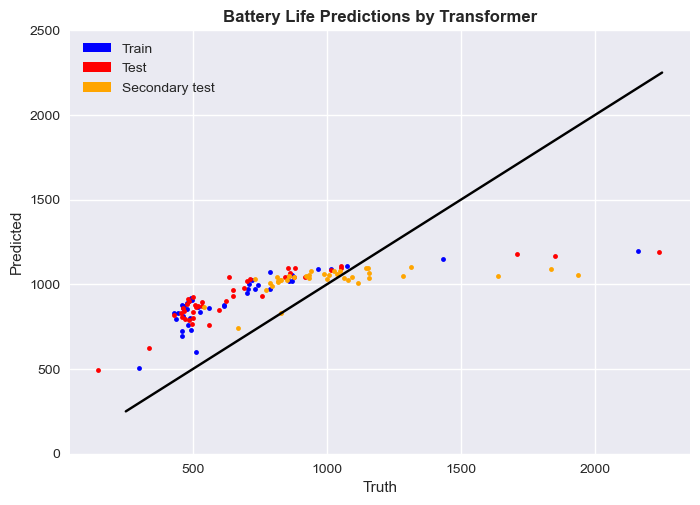

In [408]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label, true_life = cell
        pred = model(input[None,:].to(device)).detach().numpy()[0]
        pred_life = np.power(np.exp(-pred[0])*(0.2-pred[2]),1/pred[1])
        #true_life = np.power(np.exp(-label[0])*(0.2-label[2]),1/label[1])

        predicted.append(pred_life)
        labels.append(true_life[0])
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_ylim([0,2500])
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
plt.savefig('greaterror.png')